<a href="https://colab.research.google.com/github/brunoegs/DiploDatos2021/blob/main/intro-aprendizaje-automatico/entregables/entregable-parte-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [ ]:
# TODO: Agregar las librerías que hagan falta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics as ms
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from scipy import stats
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')


## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [ ]:
! git clone https://github.com/DiploDatos/IntroduccionAprendizajeAutomatico

dataset = pd.read_csv("/content/IntroduccionAprendizajeAutomatico/data/loan_data.csv", comment="#") 

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

dataset.head(1)

fatal: destination path 'IntroduccionAprendizajeAutomatico' already exists and is not an empty directory.


,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023



Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

1- El dataset contiene datos recopilados de solicitantes de créditos recientes a los que se les otorgó el crédito a través del proceso actual de suscripción de préstamos. El conjunto de datos sobre el valor líquido de la vivienda (HMEQ) contiene información de referencia y de rendimiento de préstamos para 5,960 préstamos sobre el valor líquido de la vivienda recientes. Para cada solicitante, se registraron 12 variables de entrada.

2- La variable objetivo es la variable 'TARGET', la cual es una variable binaria, que indica si un solicitante finalmente incurrió en incumplimiento o en grave mora. Esta toma los valores '1' cuando el cliente ha incumplido en el préstamo, o '0' cuando el préstamo fue reembolsado. Esta variable se utilizará para predecir  El departamento de crédito al consumo de un banco desea automatizar el proceso de toma de decisiones para la aprobación de líneas de crédito con garantía hipotecaria.

3- Los atributos que hay disponibles, además de la variable objetivo, son:

* LOAN: Monto de la solicitud de préstamo.
* MORTDUE: Monto adeudado de la hipoteca existente.
* VALUE: Valor de la propiedad actual.
* YOJ: Años en el trabajo actual.
* DEROG: Número de informes despectivos importantes.
* DELINQ: Número de líneas de crédito morosas.
* CLAGE: Edad de la línea comercial más antigua en meses.
* NINQ: Número de líneas de crédito recientes.
* CLNO: Número de líneas de crédito.
* DEBTINC: Relación deuda-ingresos.

4- Los atributos que se consideran relevantes para predecir la variable son DELINQ y DEROG, en primera instancia, ya que son los atributos con los que más se encuentran diferencias entre las etiquetas (0 y 1) de la variable objetivo. En segundo lugar YOJ, NINQ, y DEBTINC, ya que si bien se observa una diferencia entre las etiquetas, esta es menor con respecto a los casos anteriores. 

In [ ]:
dataset[['LOAN',	'MORTDUE',	'VALUE',	'YOJ',	'DEROG',	'DELINQ',	'CLAGE',	'NINQ',	'CLNO',	'DEBTINC']].groupby(dataset['TARGET']).mean().round(2)

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
TARGET,,,,,,,,,,
0,19319.55,76798.12,108209.45,9.17,0.10,0.19,186.32,1.03,21.75,33.46
1,18072.82,73905.72,102879.28,7.57,0.63,0.98,150.21,1.64,22.39,40.12


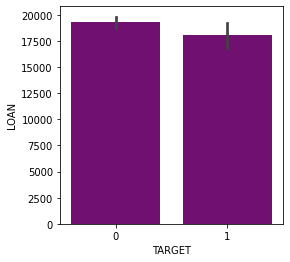

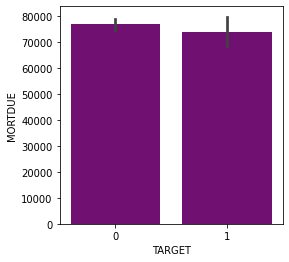

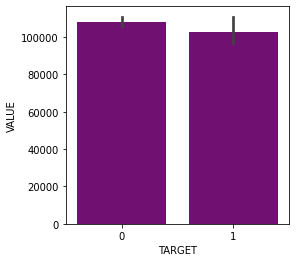

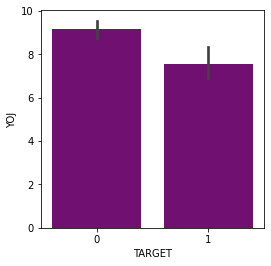

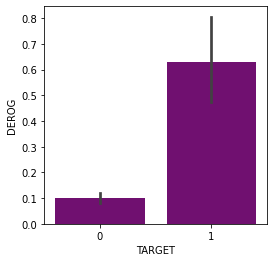

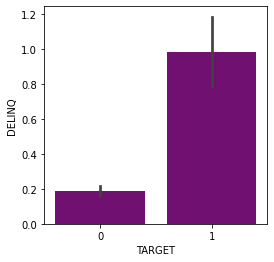

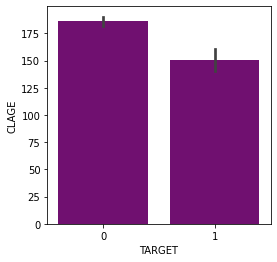

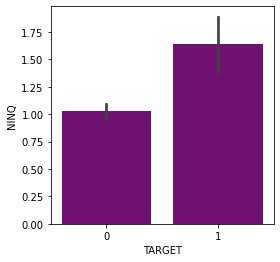

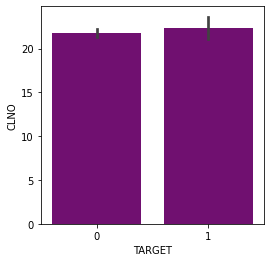

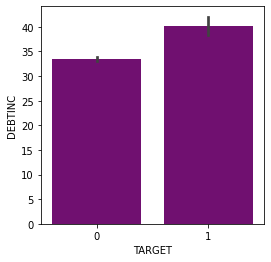

In [ ]:
columnas= [dataset['LOAN'],	dataset['MORTDUE'],	dataset['VALUE'],	dataset['YOJ'],	dataset['DEROG'],	dataset['DELINQ'], dataset['CLAGE'],	dataset['NINQ'], dataset['CLNO'], dataset['DEBTINC']]

for columna in columnas:
  fig= plt.figure(figsize= (4, 4))
  sns.barplot(dataset['TARGET'], columna, color='purple')

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [ ]:
# SGDClasifier requiere que los datos esten escalados.
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

In [ ]:
#entrenamiento
clf = SGDClassifier(random_state=0)
clf.fit(X_train_scaled, y_train)

#prediccion
y_train_predict= clf.predict(X_train_scaled)
y_test_predict= clf.predict(X_test_scaled)

#evaluacion
Reporte_test= classification_report(y_test, y_test_predict)
Reporte_train= classification_report(y_train, y_train_predict)

print(f'Entrenamiento=\n', 'Reporte train=\n', Reporte_train)
print('')
print(f'Evaluación=\n', 'Reporte test=\n', Reporte_test)

Entrenamiento=
 Reporte train=
               precision    recall  f1-score   support

           0       0.89      0.97      0.93      1232
           1       0.71      0.42      0.53       251

    accuracy                           0.87      1483
   macro avg       0.80      0.69      0.73      1483
weighted avg       0.86      0.87      0.86      1483


Evaluación=
 Reporte test=
               precision    recall  f1-score   support

           0       0.89      0.96      0.92       313
           1       0.63      0.33      0.43        58

    accuracy                           0.87       371
   macro avg       0.76      0.65      0.68       371
weighted avg       0.85      0.87      0.85       371



In [ ]:
confusion_matrix(y_test, y_test_predict)

# plot_confusion_matrix(classifier, X_test, y_test,

array([[302,  11],
       [ 39,  19]])

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
(tn, fp, fn, tp)

(302, 11, 39, 19)

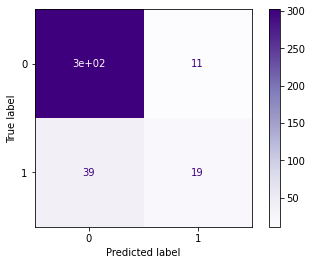

In [ ]:
plot_confusion_matrix(clf, X_test_scaled, y_test, cmap='Purples')

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
param_grid = {'loss':['hinge', 'log', 'modified_huber','squared_hinge', 'perceptron', 'squared_loss',
        'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
              'alpha': loguniform(1e-4, 1e2),
              'penalty': ['l2', 'l1', 'elasticnet']}

model_clf = SGDClassifier(random_state=0)
cv = RandomizedSearchCV(model_clf, param_grid, n_iter=10, scoring='accuracy', cv=3, random_state=0) 
cv.fit(X_train_scaled, y_train)

results = cv.cv_results_
df = pd.DataFrame(results)
df[df.rank_test_score<5][['mean_test_score', 'std_test_score', 'rank_test_score', 'params', 'param_loss', 'param_alpha']]

,mean_test_score,std_test_score,rank_test_score,params,param_loss,param_alpha
0,0.857723,0.002394,4,"{'alpha': 0.196282248134428, 'loss': 'squared_...",squared_loss,0.196282
2,0.857724,0.004031,3,"{'alpha': 0.5512926225087423, 'loss': 'modifie...",modified_huber,0.551293
3,0.859070,0.000894,2,"{'alpha': 0.0060982839082360536, 'loss': 'squa...",squared_epsilon_insensitive,0.00609828
4,0.867843,0.008351,1,"{'alpha': 0.00432451858115581, 'loss': 'log', ...",log,0.00432452


In [ ]:
cv.best_estimator_

SGDClassifier(alpha=0.00432451858115581, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
cv.best_params_

{'alpha': 0.00432451858115581, 'loss': 'log', 'penalty': 'elasticnet'}

In [ ]:
#entrenamiento
mejor_modelo = SGDClassifier(alpha= 0.00432451858115581, loss= 'log', penalty= 'elasticnet', random_state=0)
mejor_modelo.fit(X_train_scaled, y_train)

#prediccion
y_train_predict_mm= mejor_modelo.predict(X_train_scaled)
y_test_predict_mm= mejor_modelo.predict(X_test_scaled)

#evaluacion
Reporte_test_mm= classification_report(y_test, y_test_predict_mm)
Reporte_train_mm= classification_report(y_train, y_train_predict_mm)

print(f'Entrenamiento=\n', 'Reporte train mejor modelo=\n', Reporte_train_mm)
print('')
print(f'Evaluación=\n', 'Reporte test mejor modelo=\n', Reporte_test_mm)

Entrenamiento=
 Reporte train mejor modelo=
               precision    recall  f1-score   support

           0       0.88      0.98      0.93      1232
           1       0.80      0.33      0.47       251

    accuracy                           0.87      1483
   macro avg       0.84      0.66      0.70      1483
weighted avg       0.87      0.87      0.85      1483


Evaluación=
 Reporte test mejor modelo=
               precision    recall  f1-score   support

           0       0.89      0.98      0.93       313
           1       0.80      0.34      0.48        58

    accuracy                           0.88       371
   macro avg       0.85      0.66      0.71       371
weighted avg       0.88      0.88      0.86       371



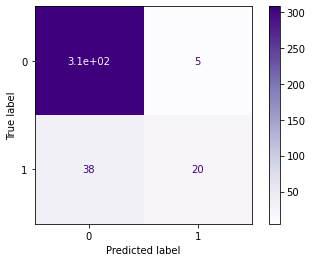

In [ ]:
plot_confusion_matrix(mejor_modelo, X_test_scaled, y_test, cmap='Purples')

#### Comparacion busqueda de hiperparametros vs hiperparametros por defecto

In [ ]:
print('Hiperparametros por defecto')
#print(f'Entrenamiento=\n', 'Reporte train=\n', Reporte_train)
#print('')
print(f'Evaluación=\n', 'Reporte test=\n', Reporte_test)
print('Ajuste de hiperparametros')
#print(f'Entrenamiento=\n', 'Reporte train mejor modelo=\n', Reporte_train_mm)
#print('')
print(f'Evaluación=\n', 'Reporte test mejor modelo=\n', Reporte_test_mm)

Hiperparametros por defecto
Evaluación=
 Reporte test=
               precision    recall  f1-score   support

           0       0.89      0.96      0.92       313
           1       0.63      0.33      0.43        58

    accuracy                           0.87       371
   macro avg       0.76      0.65      0.68       371
weighted avg       0.85      0.87      0.85       371

Ajuste de hiperparametros
Evaluación=
 Reporte test mejor modelo=
               precision    recall  f1-score   support

           0       0.89      0.98      0.93       313
           1       0.80      0.34      0.48        58

    accuracy                           0.88       371
   macro avg       0.85      0.66      0.71       371
weighted avg       0.88      0.88      0.86       371



Al realizar el ajuste de hiperparametros obtenemos mejoras, tanto en 'accuracy' como en 'f1-score', sobre el conjunto de test.

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


In [ ]:
#entrenamiento
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

#prediccion 
y_train_predict_dtc= dtc.predict(X_train)
y_test_predict_dtc= dtc.predict(X_test)

#evaluacion
Reporte_test_dtc= classification_report(y_test, y_test_predict_dtc)
Reporte_train_dtc= classification_report(y_train, y_train_predict_dtc)

print(f'Entrenamiento=\n', 'Reporte train=\n', Reporte_train_dtc)
print('')
print(f'Evaluación=\n', 'Reporte test=\n', Reporte_test_dtc)


Entrenamiento=
 Reporte train=
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1232
           1       1.00      1.00      1.00       251

    accuracy                           1.00      1483
   macro avg       1.00      1.00      1.00      1483
weighted avg       1.00      1.00      1.00      1483


Evaluación=
 Reporte test=
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       313
           1       0.62      0.64      0.63        58

    accuracy                           0.88       371
   macro avg       0.77      0.78      0.78       371
weighted avg       0.88      0.88      0.88       371



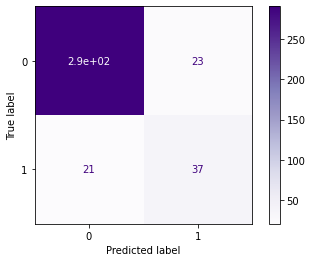

In [ ]:
plot_confusion_matrix(dtc, X_test, y_test, cmap='Purples')

[Text(289.32823606915616, 212.71304347826086, 'X[9] <= 43.681\ngini = 0.281\nsamples = 1483\nvalue = [1232, 251]'),
 Text(254.87373545857704, 203.2591304347826, 'X[5] <= 1.5\ngini = 0.227\nsamples = 1409\nvalue = [1225, 184]'),
 Text(212.8193135805643, 193.80521739130435, 'X[4] <= 1.5\ngini = 0.189\nsamples = 1313\nvalue = [1174, 139]'),
 Text(163.82799665788292, 184.3513043478261, 'X[6] <= 173.132\ngini = 0.169\nsamples = 1274\nvalue = [1155, 119]'),
 Text(94.76567902821519, 174.89739130434782, 'X[2] <= 84241.5\ngini = 0.249\nsamples = 612\nvalue = [523, 89]'),
 Text(56.37740214666753, 165.44347826086957, 'X[0] <= 16850.0\ngini = 0.345\nsamples = 257\nvalue = [200, 57]'),
 Text(30.125329391349062, 155.98956521739132, 'X[2] <= 50823.0\ngini = 0.413\nsamples = 168\nvalue = [119, 49]'),
 Text(5.5086316601324, 146.53565217391304, 'X[6] <= 69.725\ngini = 0.499\nsamples = 40\nvalue = [21, 19]'),
 Text(2.7543158300662, 137.08173913043478, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]'),
 Text(8

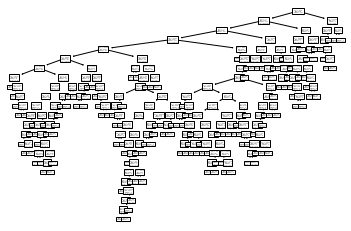

In [ ]:
plot_tree(dtc)

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
DecisionTreeClassifier??

In [ ]:
param_grid_dtc = {'criterion': ['gini', 'entropy'],
                  'max_depth': [1, 2, 3, 4, 5, 10],
                  'min_samples_split':[2, 5, 10]}

model_dtc = DecisionTreeClassifier(random_state=0)

cv_dtc = GridSearchCV(model_dtc, param_grid_dtc, scoring='accuracy', cv=3)
cv_dtc.fit(X_train, y_train);

results_dtc = cv_dtc.cv_results_
df_dtc = pd.DataFrame(results_dtc)
df_dtc[df_dtc.rank_test_score<5][['mean_test_score', 'std_test_score', 'params', 'param_criterion', 'param_max_depth', 'rank_test_score']]

,mean_test_score,std_test_score,params,param_criterion,param_max_depth,rank_test_score
15,0.878631,0.009105,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",gini,10,1
27,0.875270,0.017686,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",entropy,4,4
28,0.875943,0.016743,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",entropy,4,2
29,0.875943,0.016743,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",entropy,4,2


In [ ]:
cv_dtc.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
cv_dtc.best_params_

{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}

In [ ]:
#entrenamiento
dtc_mejor_modelo = DecisionTreeClassifier(criterion= 'gini', max_depth= 10, min_samples_split= 2, random_state=0)
dtc_mejor_modelo.fit(X_train, y_train)

#evaluacion 
y_train_predict_dtc_mm= dtc_mejor_modelo.predict(X_train)
y_test_predict_dtc_mm= dtc_mejor_modelo.predict(X_test)

#evaluacion
Reporte_test_dtc_mm= classification_report(y_test, y_test_predict_dtc_mm)
Reporte_train_dtc_mm= classification_report(y_train, y_train_predict_dtc_mm)

print(f'Entrenamiento=\n', 'Reporte train mejor modelo=\n', Reporte_train_dtc_mm)
print('')
print(f'Evaluación=\n', 'Reporte test mejor modelo=\n', Reporte_test_dtc_mm)


Entrenamiento=
 Reporte train mejor modelo=
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1232
           1       0.99      0.75      0.85       251

    accuracy                           0.96      1483
   macro avg       0.97      0.87      0.91      1483
weighted avg       0.96      0.96      0.95      1483


Evaluación=
 Reporte test mejor modelo=
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       313
           1       0.74      0.53      0.62        58

    accuracy                           0.90       371
   macro avg       0.83      0.75      0.78       371
weighted avg       0.89      0.90      0.89       371



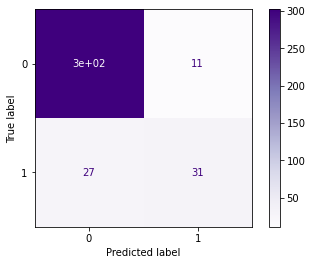

In [ ]:
plot_confusion_matrix(dtc_mejor_modelo, X_test, y_test, cmap='Purples')

[Text(272.041875, 207.55636363636364, 'X[9] <= 43.681\ngini = 0.281\nsamples = 1483\nvalue = [1232, 251]'),
 Text(226.56375000000003, 187.7890909090909, 'X[5] <= 1.5\ngini = 0.227\nsamples = 1409\nvalue = [1225, 184]'),
 Text(177.72750000000002, 168.0218181818182, 'X[4] <= 1.5\ngini = 0.189\nsamples = 1313\nvalue = [1174, 139]'),
 Text(135.13500000000002, 148.25454545454545, 'X[6] <= 173.132\ngini = 0.169\nsamples = 1274\nvalue = [1155, 119]'),
 Text(95.31, 128.48727272727274, 'X[2] <= 84241.5\ngini = 0.249\nsamples = 612\nvalue = [523, 89]'),
 Text(58.86000000000001, 108.72, 'X[0] <= 16850.0\ngini = 0.345\nsamples = 257\nvalue = [200, 57]'),
 Text(31.32, 88.95272727272729, 'X[2] <= 50823.0\ngini = 0.413\nsamples = 168\nvalue = [119, 49]'),
 Text(8.64, 69.18545454545455, 'X[6] <= 69.725\ngini = 0.499\nsamples = 40\nvalue = [21, 19]'),
 Text(4.32, 49.418181818181836, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]'),
 Text(12.96, 49.418181818181836, 'X[0] <= 9700.0\ngini = 0.464\nsamples = 3

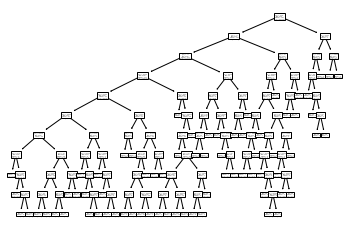

In [ ]:
plot_tree(dtc_mejor_modelo)

#### Comparacion entre hiperparametros por defecto y busqueda de hiperparametros

In [ ]:
print(f'Evaluación sin ajuste=\n', 'Reporte test=\n', Reporte_test_dtc)
print('')
print(f'Evaluación con ajuste de hiperparametros=\n', 'Reporte test mejor modelo=\n', Reporte_test_dtc_mm)
#print(f'Entrenamiento sin ajuste=\n', 'Reporte train=\n', Reporte_train_dtc)
#print('')
#print(f'Entrenamiento con ajuste de hiperparametros=\n', 'Reporte train mejor modelo=\n', Reporte_train_dtc_mm)
#print('==============================')

Evaluación sin ajuste=
 Reporte test=
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       313
           1       0.62      0.64      0.63        58

    accuracy                           0.88       371
   macro avg       0.77      0.78      0.78       371
weighted avg       0.88      0.88      0.88       371


Evaluación con ajuste de hiperparametros=
 Reporte test mejor modelo=
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       313
           1       0.74      0.53      0.62        58

    accuracy                           0.90       371
   macro avg       0.83      0.75      0.78       371
weighted avg       0.89      0.90      0.89       371



Observando el reporte sobre el conjunto de test, vemos que el modelo con ajuste de hiperparametros tiene mejor resultado respecto a accuracy, que es la metrica utilizada para buscar hiperparametros, y disminuye su performance respecto a f1-score, particularmente respecto a la metrica 'recall'. 

Los resultados del modelo 'Arbol de decision' fueron superiores, tanto en 'accuracy' como en 'f1-score', a los modelos lineales.

